In [8]:
import plotly.graph_objects as go
import plotly.express as px

In [9]:
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,auc,f1_score,confusion_matrix, \
mean_absolute_error,mean_squared_error,RocCurveDisplay,ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import re
import datetime as dt
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
import os
from sklearn.preprocessing import LabelEncoder

In [10]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve,auc

In [11]:
df=pd.read_csv(os.path.join(os.getcwd()+'/All Countries.csv'))

In [20]:
df.rename(columns=lambda x: re.sub('\W+','',x).strip().replace(' ','_').lower(),inplace=True)

In [26]:
df.country_long.replace(' ','_',regex=True)

0                           Islamic_State_of_Afghanistan
1                                    Republic_of_Albania
2                People's_Democratic_Republic_of_Algeria
3                                Principality_of_Andorra
4                            People's_Republic_of_Angola
5                                    Antigua_and_Barbuda
6                                     Argentine_Republic
7                                    Republic_of_Armenia
8                              Commonwealth_of_Australia
9                                    Republic_of_Austria
10                                Republic_of_Azerbaijan
11                                    Kingdom_of_Bahrain
12                       People's_Republic_of_Bangladesh
13                                              Barbados
14                                   Republic_of_Belarus
15                                    Kingdom_of_Belgium
16                                                Belize
17                             

In [32]:
df.assign(empty=np.where(df.country.isnull(),True,False))

,country,country_long,currency,capital_city,region,continent,demonym,latitude,longitude,agricultural_land,forest_area,land_area,rural_land,urban_land,central_government_debt_pct_gdp,expense_pct_gdp,gdp,inflation,self_employed_pct,tax_revenue_pct_gdp,unemployment_pct,vulnerable_employment_pct,electricity_access_pct,alternative_nuclear_energy_pct,electricty_production_coal_pct,electricty_production_hydroelectric_pct,electricty_production_gas_pct,electricty_production_nuclear_pct,electricty_production_oil_pct,electricty_production_renewable_pct,energy_imports_pct,fossil_energy_consumption_pct,renewable_energy_consumption_pct,co2_emissions,methane_emissions,nitrous_oxide_emissions,greenhouse_other_emissions,urban_population_under_5m,health_expenditure_pct_gdp,health_expenditure_capita,hospital_beds,hiv_incidence,suicide_rate,armed_forces,internally_displaced_persons,military_expenditure_pct_gdp,birth_rate,death_rate,fertility_rate,internet_pct,life_expectancy,net_migration,population_female,population_male,population,women_parliament_seats_pct,rural_population,urban_population,press,democracy_score,democracy_type,median_age,political_leader,title,empty
0,Afghanistan,Islamic State of Afghanistan,Afghan afghani,Kabul,Southern Asia,Asia,Afghan,33.000000,65.000000,383560.00,12084.4,6.522300e+05,6.361730e+05,3993.84000,NaN,39.220100,1.458310e+10,2.302370,84.33390,9.898450,11.710,82.690700,97.70000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.86,8.709470e+03,1.622200e+04,4863.390000,-1800.00000,0.000000,16.82610,81.3198,0.3900,0.04,4.1,278000.0,4394000.0,1.358860,35.842,7.344,4.643,18.40000,62.0,-183672,20362329,20766442,41128771,27.01610,30181937,10946834,2.14,2.97,Authoritarian,12.9,Ashraf Ghani,President,False
1,Albania,Republic of Albania,Albanian lek,Tirana,Southern Europe,Europe,Albanian,41.000000,20.000000,11655.50,7889.0,2.740000e+04,2.733160e+04,827.69400,82.38360,24.536300,1.888210e+10,6.725200,53.04550,18.198600,11.808,50.062400,100.00000,24.548000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,13.79800,61.42180,44.58,4.383200e+03,2.692200e+03,1015.190000,11.68140,6.367260,6.65959,350.8350,2.8900,0.03,4.3,8000.0,NaN,1.415640,10.240,11.325,1.390,79.32000,76.0,-10612,1391085,1384548,2775634,35.71430,1004807,1770827,2.62,5.98,Hybrid regime,33.7,Edi Rama,Prime Minister,False
2,Algeria,People's Democratic Republic of Algeria,Algerian dinar,Algiers,Northern Africa,Africa,Algerian,28.000000,3.000000,413588.00,19490.0,2.381740e+06,2.305480e+06,9357.10000,NaN,NaN,1.919130e+11,9.265520,30.52590,NaN,11.550,26.071200,99.78780,0.030106,0.000000,0.210762,98.357500,0.000000,1.319810,0.111922,-177.12400,99.97790,0.15,1.615630e+05,8.654390e+04,12578.700000,-7720.56000,1.124750,6.32118,214.8520,1.9000,0.04,2.5,317000.0,2500.0,5.592580,21.524,4.546,2.889,70.77000,76.0,-18797,22040987,22862237,44903225,8.10811,11328186,33575039,1.71,3.50,Authoritarian,24.0,Abdelmadjid Tebboune,President,False
3,Andorra,Principality of Andorra,Euro,Andorra la Vella,Southern Europe,Europe,Andorran,42.500000,1.500000,187.20,160.0,4.700000e+02,4.094970e+02,30.93580,NaN,NaN,3.352030e+09,NaN,NaN,NaN,NaN,NaN,100.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.59,4.488840e+02,5.360100e+01,1.758810,NaN,0.000000,9.05176,3336.9200,2.5000,NaN,NaN,NaN,NaN,NaN,7.000,3.900,1.270,93.89750,NaN,1377,39038,40786,79824,46.42860,9730,70094,3.17,0.00,Unknown,38.9,Xavier Espot Zamora,Head of Government,False
4,Angola,People's Republic of Angola,Angolan kwanza,Luanda,Middle Africa,Africa,Angolan,-12.500000,18.500000,569525.00,666074.0,1.246700e+06,1.251000e+06,2991.35000,NaN,16.685000,1.067140e+11,25.754300,65.85220,10.090400,10.209,61.325200,48.22390,2.548840,0.000000,53.174900,0.000000,0.000000,46.825100,0.000000,-540.99700,48.30560,61.02,1.981450e+04,3.270320e+04,17757.900000,5203.07000,1.220310,2.91183,50.7426,0.8000,0.52,6.1,117000.0,NaN,1.132060,38.809,8.009,5.304,32.60230,62.0,29089,17998220,17590767,35588987,33.63640,11359649,24229338,2.24,3.62,Authoritarian,12.4,João Lourenço,

In [33]:
def auc_score(model,X,y):
    rf_probs=model.predict_proba(X)
    rf_probs=rf_probs[:,1]
    predict=model.predict(X)
    rf_precision,rf_recall,_=precision_recall_curve(y,rf_probs)
    rf_f1,rf_auc=f1_score(y,predict),auc(rf_recall,rf_precision)
    return rf_f1,rf_auc

def rmse(model,X,y):
    rmse=np.sqrt(mean_squared_error(y,model.predict(X)))
    return rmse


In [34]:
def check_parameters(parameters,values,fixed={},features=None):
    scores=[]
    f1=[]
    auc=[]
    for p in values:
        print(f'Fitting with {parameters}={p}')
        fts=X_train.columns if features is None else features
        kws={parameters:p,**fixed}
        model=RandomForestClassifier(**kws)
        %time model.fit(X_train[fts],y_train)
        s=roc_auc_score(y_valid,model.predict_proba(X_valid[fts])[:,1])
        rf_f1,rf_auc=auc_score(model,X_valid[fts],y_valid)
        print('ROC_AUC',s)
        print('F1',f1)
        print('AUC',auc)
        scores.append(s)
        f1.append(rf_f1)
        auc.append(rf_auc)
    plt.title(parameters)
    plt.plot(values,scores)
    return plt.show()

In [35]:
def split_df(df,ln_train,ln_valid):
    df=df.sample(frac=1.).reset_index(drop=True)
    val=df.iloc[-ln_valid:].reset_index(drop=True)
    train=df.iloc[:ln_valid].reset_index(drop=True)
    has_yes=train[train.yes==True]
    has_not_yes=train[train.yes==False].head(ln_train-len(has_yes))
    tra=pd.concat([has_yes,has_not_yes],axis=0).reset_index(drop=True)
    return tra,val

In [32]:
cat_cols=df.select_dtypes(exclude=[np.number]).columns

In [33]:
df.drop(cat_cols[1:],axis=1,inplace=True)

In [34]:
cat_cols=df.select_dtypes(exclude=[np.number]).columns

In [38]:
df=df.assign(yes=np.where(df.country.str.contains('A'),True,False))

In [ ]:
def encode_features(features,df_train,df_test):
    df_combined=pd.concat(df_train[features],df_test[features])
    le_name_mapping=[]
    for f in features:
        le=LabelEncoder()
        le=le.fit(df_train[features])
        le_list=dict(zip(le.classes_,le.transform(le.classes_)))
        df_train[features]=le.transform(df_train[features])
        df_test[features]=le.transform(df_test[features])
        le_name_mapping.append(le_list)
    le_name_mapping=pd.Series(le_name_mapping)
    return df_train,df_test,le_name_mapping

        

In [44]:
le=LabelEncoder()
le=le.fit(df.country)

le_name_mapping=dict(zip(le.classes_,le.transform(le.classes_)))

df['encoded_country']=le.transform(df.country)

df.drop('country',axis=1,inplace=True)


In [45]:
df.yes.value_counts()

False    178
True      16
Name: yes, dtype: int64

In [46]:
num_cols=df.select_dtypes(include=[np.number]).columns

In [135]:
len(num_cols)

54

In [47]:
for col in num_cols:
    df[col].fillna(df[col].median(),inplace=True)

In [52]:
model_df=df

In [53]:
train,valid=split_df(model_df,50,50)

In [55]:
X_train,y_train=train.drop('yes',axis=1),train['yes']
X_valid,y_valid=valid.drop('yes',axis=1),valid['yes']

In [147]:
d={'n_estimators':100,'n_jobs':-1}
p='min_samples_leaf'
v=[1,3,5,10]

Fitting with min_samples_leaf=1
CPU times: user 3.28 s, sys: 619 ms, total: 3.9 s
Wall time: 3.68 s
ROC_AUC 0.8478260869565217
F1 []
AUC []
Fitting with min_samples_leaf=3
CPU times: user 3.16 s, sys: 531 ms, total: 3.69 s
Wall time: 3.43 s
ROC_AUC 0.8260869565217391
F1 [0.0]
AUC [0.19720522533022533]
Fitting with min_samples_leaf=5
CPU times: user 3.11 s, sys: 526 ms, total: 3.63 s
Wall time: 3.54 s
ROC_AUC 0.7934782608695653
F1 [0.0, 0.0]
AUC [0.19720522533022533, 0.20746022768081593]
Fitting with min_samples_leaf=10
CPU times: user 3.1 s, sys: 470 ms, total: 3.57 s
Wall time: 3.58 s
ROC_AUC 0.7554347826086957
F1 [0.0, 0.0, 0.0]
AUC [0.19720522533022533, 0.20746022768081593, 0.18934433621933622]


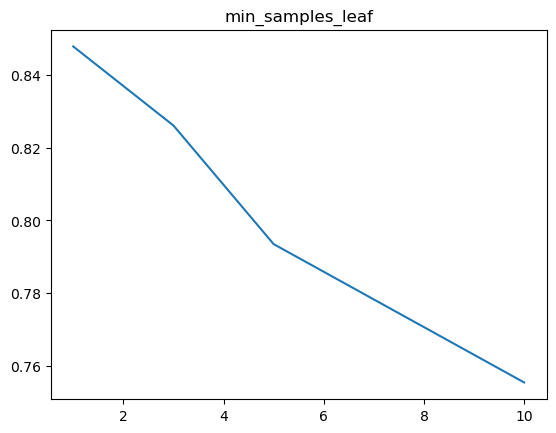

In [59]:
check_parameters(p,v,d)

In [160]:
d={'n_estimators':1000,'n_jobs':-1,'min_samples_leaf':10,'max_features':'sqrt',
   'class_weight':'balanced', 'random_state':428}

In [161]:
model=RandomForestClassifier(**d)

In [162]:
%time model.fit(X_train,y_train)

CPU times: user 2.03 s, sys: 562 ms, total: 2.59 s
Wall time: 2.12 s


RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                       n_estimators=1000, n_jobs=-1, random_state=428)

In [ ]:
def print_report(model,train,valid,target_label,feats=None):
    X_train,y_train=train.drop([target_label],axis=1),train[target_label].values
    X_valid,y_valid = valid.drop([target_label],axis=1).valid[target_label].values
    if feats is not None:
        X_train,X_valid=X_train[feats],X_valid[feats]
    train_pred,valid_pred=model.predict(X_train),model.predict(X_valid)
    roc_auc_train=roc_auc_score(y_train,model.predict_proba(X_train)[:,1])
    roc_auc_valid=roc_auc_score(y_valid,model.predict_probs(X_valid)[:,1])
    train_f1,train_auc=auc_score(model,X_train,y_train)
    valid_f1,valid_auc=auc_score(model,X_valid,y_valid)
    
    res=f"""
    Training ROC_AUC :{roc_auc_train}
    Training F1:{ train_f1}
    Training AUC :{train_auc}
    
    Validation
    
    """
    print(res)
    
    plot_roc_curve(model,X_valid,y_valid)
    plot_confusion_matrix(model,X_valid,y_valid)
    tn,fp,fn,tp=confusion_matrix(y_valid,valid_pred).ravel()
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    
    print('Recall')

In [ ]:
def print_report(model,train,valid,target_label,feats=None):
    X_train,y_train = train.drop([target_label],axis=1),train[target_label].values
    X_valid,y_valid = 
    if feats is not None:
        X_train,X_valid=X_train[feats],X_valid[feats]
    train_pred,valid_pred=model.predict(X_train),model.predict(X_valid)
    roc_auc_train=roc_auc_score(y_train,model.predict_probs(X_train)[:,1])
    roc_auc_valid =
    train_f1,train_auc= auc_score(model,X_train,y_train)
    
    res= f"""
    Training ROC AUC :{}
    
    """
    print(res)
    
    RocCurveDisplay.from_estimator(model,X_valid,y_valid)
    ConfusionMatrixDisplay.from_estimator(model,X_valid,y_valid)
    tn,fp,fn,tp=confusion_matrix(y_valid,valid_pred).ravel()
    

In [60]:
valid_pred=model.predict(X_valid)

NameError: name 'model' is not defined

In [169]:
tn,fp,fn,tp=confusion_matrix(y_valid,valid_pred).ravel()

In [176]:
perm=permutation_importance(model,X_train,y_train,n_repeats=5,n_jobs=-1)

In [181]:
perm=pd.DataFrame({'importance':perm.importances_mean,'feature':X_train.columns})

In [63]:
n_estimators=[int(x) for x in np.linspace(200,2000,num=10)]

max_features=['auto','sqrt']

max_depth=[int(x) for x in np.linspace(10,110,num=11)]

max_depth.append(None)

min_samples_leaf=[3,5,10]

min_samples_split=[1,2,4]

bootstrap=[True,False]

random_grid={'n_estimators':n_estimators,
            'max_features':max_features,
            'max_depth':max_depth,
            'min_samples_leaf':min_samples_leaf,
            'min_samples_split':min_samples_split,
            'bootstrap':bootstrap}



In [200]:
random_grid

rf=RandomForestRegressor()

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_leaf': [3, 5, 10],
 'min_samples_split': [1, 2, 4],
 'bootstrap': [True, False]}

In [203]:
rf_random=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=100,cv=3,
                   verbose=2,random_state=42,n_jobs=-1
      )

In [204]:
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/tea/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
180 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
103 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tea/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tea/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/tea/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/Users/tea/a

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [3, 5, 10],
                                        'min_samples_split': [1, 2, 4],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [205]:
def regression_report(model,X,y):
    
    predict=model.predict(X_valid)
    rmse_valid=rmse(model,X_valid,y_valid)
    rmse_train=rmse(model,X_train,y_train)
    print('RMSE Valid',rmse_valid)
    print('RMSE Train',rmse_train)
    return rmse_valid

In [207]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=3,
                      n_estimators=400)

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=1, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=1, n_estimators=1600; total time=   0.0s
[CV] END bootstrap=True, max_dept

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=2000; total time=   5.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=1200; total time=   2.4s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=1000; total time=   2.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=1, n_estimators=1000; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=1, n_estimators=1000; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=1, n_estimators=1000; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1800; total time=   0.0s
[CV] END bootstrap=False, max_dep

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=2000; total time=   5.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=800; total time=   1.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=1000; total time=   2.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=800; total time=   2.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=1600; total time=   2.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=1600; total time=   4.2s
[CV] END bootstrap=False, max_depth=3

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=2000; total time=   5.9s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=800; total time=   1.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=600; total time=   1.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=600; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=2000; total time=   3.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=1600; total time=   3.9s
[CV] END bootstrap=False, max_depth=50,

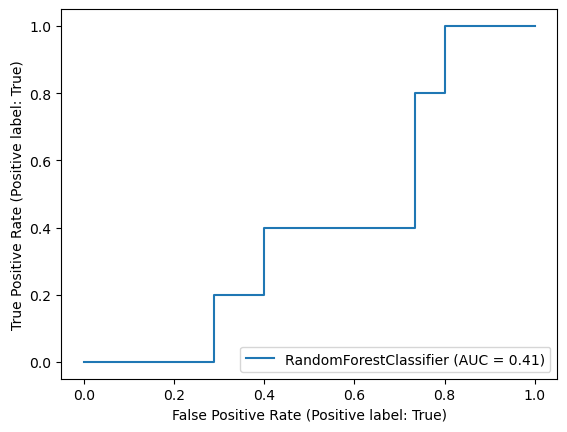

In [216]:
RocCurveDisplay.from_estimator(model,X_valid,y_valid)

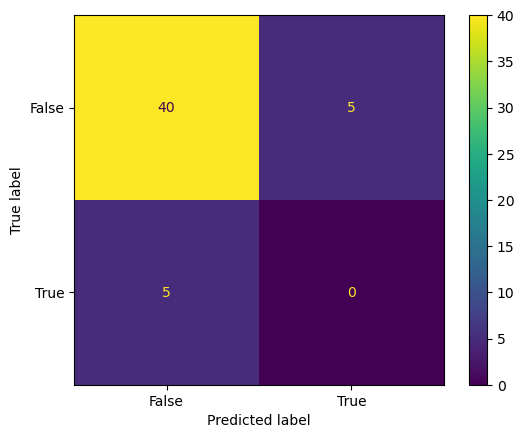

In [218]:
ConfusionMatrixDisplay.from_estimator(model,X_valid,y_valid)

https://medium.com/codex/say-goodbye-to-matplotlib-and-seaborn-for-your-python-plots-5cade2f7fba2mm


## Graphs

In [8]:
import pandas as pd

In [25]:
import datetime as dt

In [39]:
df=pd.read_csv('https://raw.githubusercontent.com/shinokada/covid-19-stats/master/data/daily-new-confirmed-cases-of-covid-19-tests-per-case.csv')

In [40]:
pd.set_option('display.max_columns',None)

In [36]:
df.head()

,countries,code,date,avg_daily_confirmed,days_to_first_30_cases
0,Afghanistan,AFG,2020-01-02,0.0,-98.0
1,Afghanistan,AFG,2020-01-03,0.0,-97.0
2,Afghanistan,AFG,2020-01-04,0.0,-96.0
3,Afghanistan,AFG,2020-01-05,0.0,-95.0
4,Afghanistan,AFG,2020-01-06,0.0,-94.0


In [41]:
df.columns = ['Countries','Code','Date','Avg Daily Confirmed',
                'Days to first 30 Cases']

excludes = ["World", "Africa", "North America", "South America", "Asia", "Europe", "European Union", "High income", "Low income", "Lower middle income", "Oceania", "Upper middle income", "World excl. China", "World excl. China and South Korea", "International",            "World excl. China, South Korea, Japan and Singapore","Asia excl. China"] 
df=df[~df['Countries'].isin(excludes)]

In [43]:
df.rename(columns=lambda x: x.lower().strip('').replace(' ','_'),inplace=True)

In [48]:
df['date']=pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

In [42]:
date_df=df[df.days_to_first_30_cases==0]

fig=px.scatter(date_df,x='date',y='avg_daily_confirmed',
           hover_name='countries',color='countries')

fig.update_layout({
   'title' :'Date of crossing first 30 cases '
    
    
})

In [43]:
fig=px.line(df,x='date',y='avg_daily_confirmed',color='countries')
fig.update_layout({
    'title':'Count of Avg.Confirmed Cases'
})
fig.show()

In [46]:
### 1. Preparing the data for animation - countries with most cases
includes = ['United States','Russia', 'India','Brazil','United Kingdom']
includes = ['United States']
df_mar_may = df[(df['date']>'2020-03-01') & (df['date'] <'2020-06-14')]
df_mar_may.columns = ['Countries','Code','Date','confirmed','days_since_confirmed']
df_us=df_mar_may[df_mar_may['Countries'].isin(includes)]

includes = ['India']
df_ind=df_mar_may[df_mar_may['Countries'].isin(includes)]

includes = ['Brazil']
df_brazil=df_mar_may[df_mar_may['Countries'].isin(includes)]

includes = ['Russia']
df_rus=df_mar_may[df_mar_may['Countries'].isin(includes)]

includes = ['United Kingdom']
df_uk=df_mar_may[df_mar_may['Countries'].isin(includes)]


## Customer Segmentation

In [2]:
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [49]:
from IPython.display import display,HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)


In [ ]:
https://www.kaggle.com/code/fabiendaniel/customer-segmentation

In [50]:
file=[d for d in os.listdir(os.getcwd()) if d.endswith('xlsx')][0]

df=pd.read_excel(os.path.join(os.getcwd()+f'/{file}'),nrows=10000,dtype={'CustomerID':str,})

df.rename(columns=lambda x:re.sub('\W+','',x).lower().strip(''),inplace=True)

df['invoicedate']=pd.to_datetime(df.invoicedate)

a=pd.DataFrame(df.dtypes).T.rename(index={0:'column_type'})

b=pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null_sum'})

a.append(b)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
column_type,object,object,object,int64,datetime64[ns],float64,object,object
null_sum,0,0,42,0,0,0,2291,0


In [59]:
summary=a.append(b)

summary=summary.append(pd.DataFrame((df.isnull().sum()/df.isnull().count())*100).T.rename(index={0:'null%'}))

In [13]:
summary

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
column_type,object,object,object,int64,datetime64[ns],float64,object,object
null_sum,0,0,42,0,0,0,2291,0
null%,0.0,0.0,0.42,0.0,0.0,0.0,22.91,0.0


In [7]:
df.duplicated().sum()

df.drop_duplicates(inplace=True)

In [17]:
from IPython.display import display,HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

tmp=df[['invoiceno','customerid','country']].groupby('country').count()

tmp=tmp.reset_index()

countries=tmp.country.value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In [19]:
df.columns

Index(['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate',
       'unitprice', 'customerid', 'country'],
      dtype='object')

In [62]:
temp=df.groupby(['customerid','invoiceno'],as_index=False)['invoicedate'].count()

n_products_per_basket=temp.rename(columns={'invoicedate':'n_products'})

n_products_per_basket['order_cancelled']=n_products_per_basket.invoiceno.apply(lambda x:int('C' in str(x)))

In [72]:
df_check=df[df.quantity<0][['customerid','quantity','stockcode','description']]

In [78]:
for idx,col in df_check.iterrows():
    if df[(df.customerid==col[0])&(df.quantity==-col[1])&(df.description==col[2])].shape[0]==0:
        print(idx)
        print(df_check.loc[idx])
        break

141
customerid        14527
quantity             -1
stockcode             D
description    Discount
Name: 141, dtype: object


In [13]:
df_cleaned=df.copy(deep=True)

In [17]:
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [8]:
df['total_price']=df.unitprice*df.quantity

temp=df.groupby(['customerid','invoiceno'],as_index=False)['total_price'].sum()

basket_price=temp.rename(columns={'total_price':'basket_price'})

df['date_int']=df.invoicedate.astype('int')

temp=df.groupby(['customerid','invoiceno'],as_index=False)['date_int'].mean()



df.drop(['date_int'],axis=1,inplace=True)

basket_price.loc[:,'invoicedate']=pd.to_datetime(temp.date_int)

basket_price=basket_price[basket_price.basket_price>0]

In [78]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []

In [10]:
for i,price in enumerate(price_range):
    if i==0: continue
    val = basket_price[(basket_price.basket_price<price) 
        &(basket_price.basket_price>price_range[i-1])]['basket_price'].count()
    count_price.append(val)

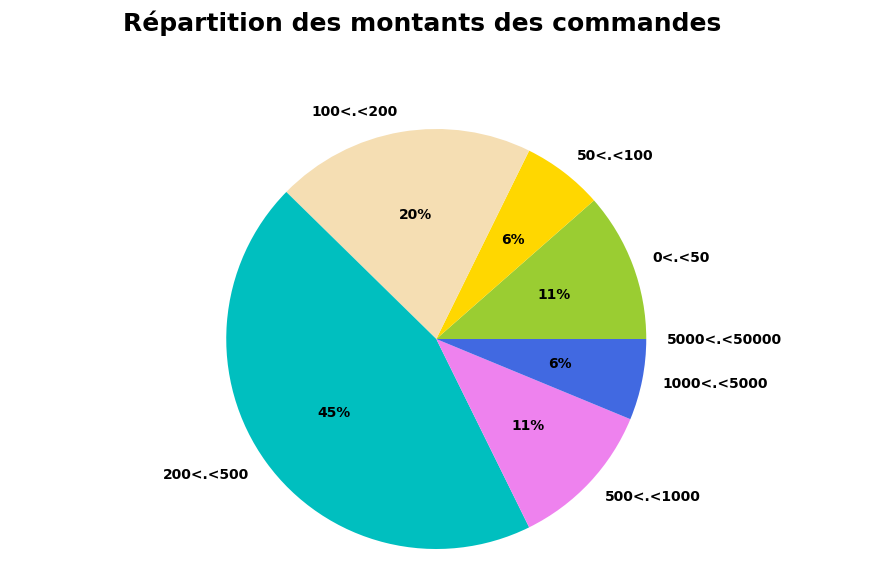

In [54]:
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Répartition des montants des commandes", ha='center', fontsize = 18);

In [11]:
!pip install wordcloud --quiet

In [84]:
import nltk
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import silhouette_samples,silhouette_score

nltk.download('punkt')

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/tea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tea/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [81]:
is_noun= lambda pos:pos[:2]=='NN'
def keywords_inventory(dataframe, colonne = 'description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [82]:
df_products=pd.DataFrame(df.description.unique()).rename(columns={0:'description'})

In [85]:
kws,kws_roots,kws_select,count_kws=keywords_inventory(df_products)

Nb of keywords in variable 'description': 1052


In [16]:
list_products=[]

for k, v in count_kws.items():
    list_products.append([kws_select[k],v])

list_products.sort(key=lambda x:x[1],reverse=True)

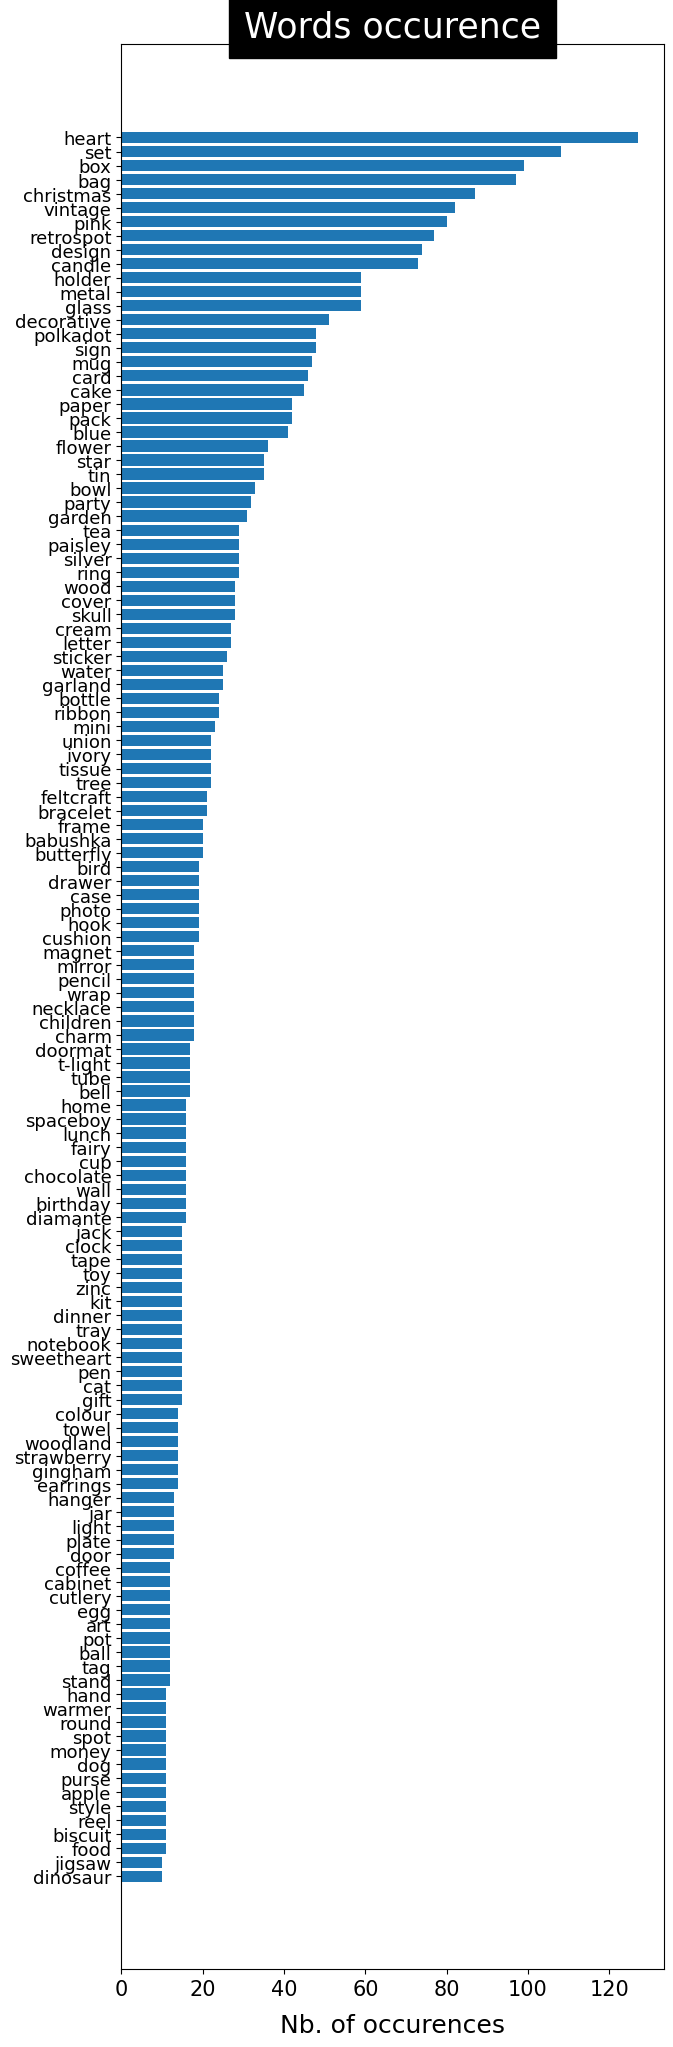

In [86]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [17]:
list_products = []
for k,v in count_kws.items():
    word = kws_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)

In [97]:
liste_produits=df.description.unique()

liste_produits=pd.DataFrame(liste_produits)[0].dropna().values

X=pd.DataFrame()


for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

In [24]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []

In [26]:
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col='.>{}'.format(threshold[i])
    else:
        col='{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:,col]=0

In [28]:
for i, prod in enumerate(liste_produits):
    prix=df[df.description==prod]['unitprice'].mean()
    j=0
    while prix>threshold[j]:
        j+=1
        if j==len(threshold): break
    X.loc[i,label_col[j-1]]=1

In [29]:
matrix=X.values

In [30]:
from sklearn.cluster import KMeans

In [161]:
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.12824720134382223
For n_clusters = 4 The average silhouette_score is : 0.16347177431452325
For n_clusters = 5 The average silhouette_score is : 0.1947473385311759
For n_clusters = 6 The average silhouette_score is : 0.19197010003309672
For n_clusters = 7 The average silhouette_score is : 0.2039850422157862
For n_clusters = 8 The average silhouette_score is : 0.18505004207476616
For n_clusters = 9 The average silhouette_score is : 0.19756830409317297


In [31]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.195:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)

In [32]:
pd.Series(clusters).value_counts()

1    500
0    492
4    367
2    326
3    296
dtype: int64

In [33]:
corresp=dict()

for k, v in zip(liste_produits,clusters):
    corresp[k]=v

df['cat_product']=df.loc[:,'description'].map(corresp)

In [38]:
for i in range(5):
    col='cat_{}'.format(i)
    df_temp=df[df.cat_product==i]
    price_temp=df_temp.unitprice *df_temp.quantity
    price_temp=price_temp.apply(lambda x:x if x >0 else 0)
    df.loc[:,col]=price_temp
    df[col].fillna(0,inplace=True)

In [41]:
temp=df.groupby(['invoiceno','customerid'],as_index=False)['total_price'].sum()

basket_price=temp.rename(columns={0:'basket_price'})

In [50]:
for i in range(5):
    col='cat_{}'.format(i)
    sum_temp=df.groupby(['invoiceno','customerid'])[col].sum().values
    basket_price.loc[:,col]=sum_temp
    

In [53]:
df['int_date']=df.invoicedate.astype(int)

temp=df.groupby(['invoiceno','customerid'],as_index=False)['int_date'].mean()

basket_price.loc[:,'invoice_date']=pd.to_datetime(temp.int_date)

df.drop('int_date',axis=1,inplace=True)

basket_price=basket_price[basket_price.total_price>0]

In [70]:
set_entrainement = basket_price[basket_price['invoice_date'] < '2011-10-01']
set_test         = basket_price[basket_price['invoice_date'] >= '2011-10-01']
basket_price = set_entrainement.copy(deep = True)

In [71]:
basket_price.head()

,invoiceno,customerid,total_price,cat_0,cat_1,cat_2,cat_3,cat_4,invoice_date
0,536365,17850,139.12,22.0,0.00,0.0,15.30,101.82,2010-12-01 08:26:00
1,536366,17850,22.20,11.1,11.10,0.0,0.00,0.00,2010-12-01 08:28:00
2,536367,13047,278.73,86.8,54.08,0.0,93.00,44.85,2010-12-01 08:34:00
3,536368,13047,70.05,0.0,0.00,0.0,0.00,70.05,2010-12-01 08:34:00
4,536369,13047,17.85,0.0,0.00,0.0,17.85,0.00,2010-12-01 08:35:00


In [73]:
transactions_per_user=basket_price.groupby(['customerid'])['total_price'].agg(['count','min','max','mean','sum'])

In [77]:
for i in range(5):
    col = 'cat_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['customerid'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)


In [84]:
last_date=basket_price.invoice_date.max().date()

first_registration=pd.DataFrame(basket_price.groupby(['customerid'])['invoice_date'].min())

last_purchase=pd.DataFrame(basket_price.groupby(['customerid'])['invoice_date'].max())

In [108]:
test=first_registration.applymap(lambda x:(last_date-x.date()).days)
test2=last_purchase.applymap(lambda x:(last_date-x.date()).days)

In [120]:
transactions_per_user.loc[:,'LastPurchase']=test2.reset_index().invoice_date
transactions_per_user.loc[:,'FirstPurchase']=test.reset_index().invoice_date

In [79]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

,customerid,count,min,max,mean,sum,cat_0,cat_1,cat_2,cat_3,cat_4
0,12395,1,346.10,346.10,346.100000,346.10,29.066744,15.804681,55.128576,0.000000,0.000000
1,12427,1,303.50,303.50,303.500000,303.50,28.467875,13.047776,0.000000,42.570016,15.914333
2,12431,1,358.25,358.25,358.250000,358.25,11.053733,9.881368,0.000000,59.637125,19.427774
3,12433,1,1919.14,1919.14,1919.140000,1919.14,30.857572,33.833905,22.485071,2.938816,9.884636
4,12472,1,1631.30,1631.30,1631.300000,1631.30,40.997977,23.294305,13.939803,6.111690,15.656225
5,12557,1,620.00,620.00,620.000000,620.00,76.612903,23.387097,0.000000,0.000000,0.000000
6,12567,1,1526.92,1526.92,1526.920000,1526.92,48.080450,10.904304,3.819454,17.646635,19.549158
7,12583,1,855.86,855.86,855.860000,855.86,22.713995,12.899306,10.090435,0.000000,54.296263
8,12600,1,76.50,76.50,76.500000,76.50,100.000000,0.000000,0.000000,0.000000,0.000000
9,12647,2,85.50,286.50,186.000000,372.00,30.000000,4.677419,5.483871,39.865591,19.973118


In [129]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

scaler_matrix=scaler.fit_transform(matrix)

from sklearn.decomposition import PCA



pca=PCA()

pca_samples=pca.fit_transform(scaler_matrix)

In [142]:
matrix.shape[1]

9

In [139]:
pca.explained_variance_ratio_

array([2.93057294e-01, 1.75840744e-01, 1.54267758e-01, 1.29614113e-01,
       1.16242534e-01, 9.56212100e-02, 3.50383789e-02, 3.17967966e-04,
       5.26698145e-33])

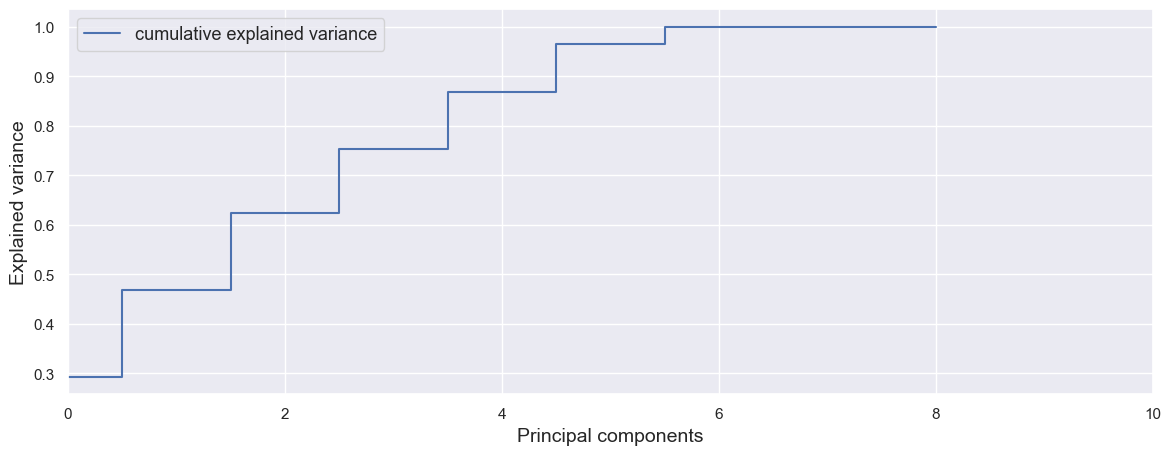

In [146]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')

plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);